# Prelude

In [2]:
# Utilities
import numpy as np
import pathlib

# ML libraries
import tensorflow as tf
from tensorflow.keras import layers

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Access dataset using paths
frames = pathlib.Path("./frames")

train_frames = frames / "train"
train_norm_frames = train_frames / "norm"
train_weap_frames = train_frames / "weap"

test_frames = frames / "test"
test_norm_frames = test_frames / "norm"
test_weap_frames = test_frames / "weap"

In [4]:
# Basic dataset statistics
print("Number of training frames: {}".format(len(list(train_frames.glob("**/*.png")))))
print("Training frames statistics:")
print("\tNumber of normal frames: {}".format(len(list(train_norm_frames.glob("**/*.png")))))
print("\tNumber of weapon frames: {}".format(len(list(train_weap_frames.glob("**/*.png")))))
print()
print("Number of testing frames: {}".format(len(list(test_frames.glob("**/*.png")))))
print("Testing frames statistics:")
print("\tNumber of normal frames: {}".format(len(list(test_norm_frames.glob("**/*.png")))))
print("\tNumber of weapon frames: {}".format(len(list(test_weap_frames.glob("**/*.png")))))

Number of training frames: 3537
Training frames statistics:
	Number of normal frames: 2059
	Number of weapon frames: 1478

Number of testing frames: 2071
Testing frames statistics:
	Number of normal frames: 1292
	Number of weapon frames: 779


# Loading dataset

In [5]:
# Load dataset
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_frames,
    validation_split=0.2,
    subset="both",
    seed=123,
    batch_size=batch_size
)

Found 3537 files belonging to 2 classes.
Using 2830 files for training.
Using 707 files for validation.


In [6]:
# Verify class names
class_names = train_ds.class_names
print(class_names)

['norm', 'weap']


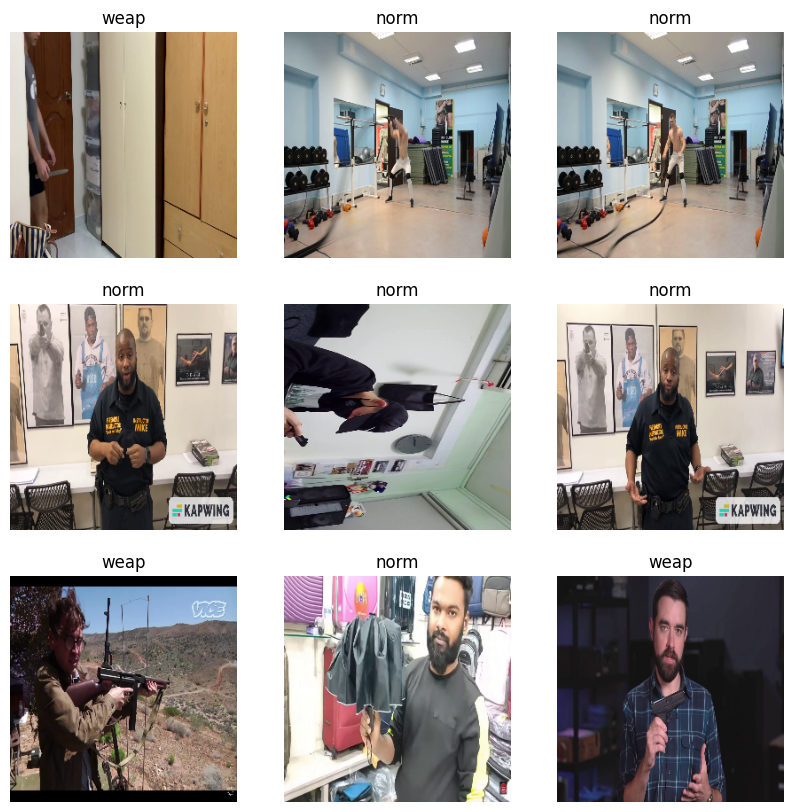

In [7]:
# Sanity check for label correctness
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Each training batch has 32 images, each of size 256 x 256 x 3
# Each label batch has 32 values, each corresponding to the labels of the images in the training batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


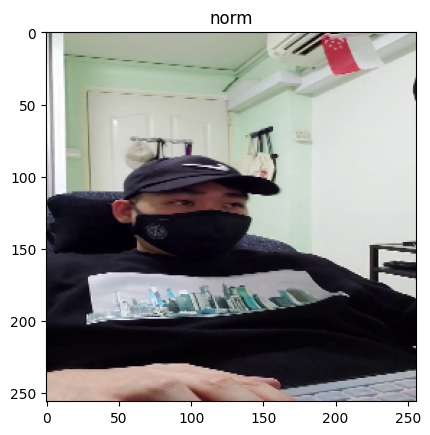

In [9]:
images, labels = next(iter(train_ds))
sample_image = images[0].numpy().astype("uint8")
sample_image_label = class_names[labels[0]]
_ = plt.imshow(sample_image)
_ = plt.title(sample_image_label)

# Data augmentation
### Resizing and rescaling images

In [10]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  # Rescaling standardizes pixel values to the [0, 1] range
  layers.Rescaling(1./255)
])

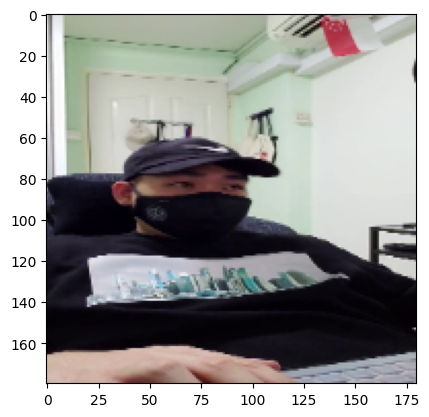

In [11]:
# Apply resize_and_rescale on an image
result = resize_and_rescale(sample_image)
plt.imshow(result)

In [12]:
# Verify that the pixels are in the [0, 1] range:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### Randomly flip and rotate images

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [14]:
# Add the image to a batch.
sample_image = tf.cast(tf.expand_dims(sample_image, 0), tf.float32)

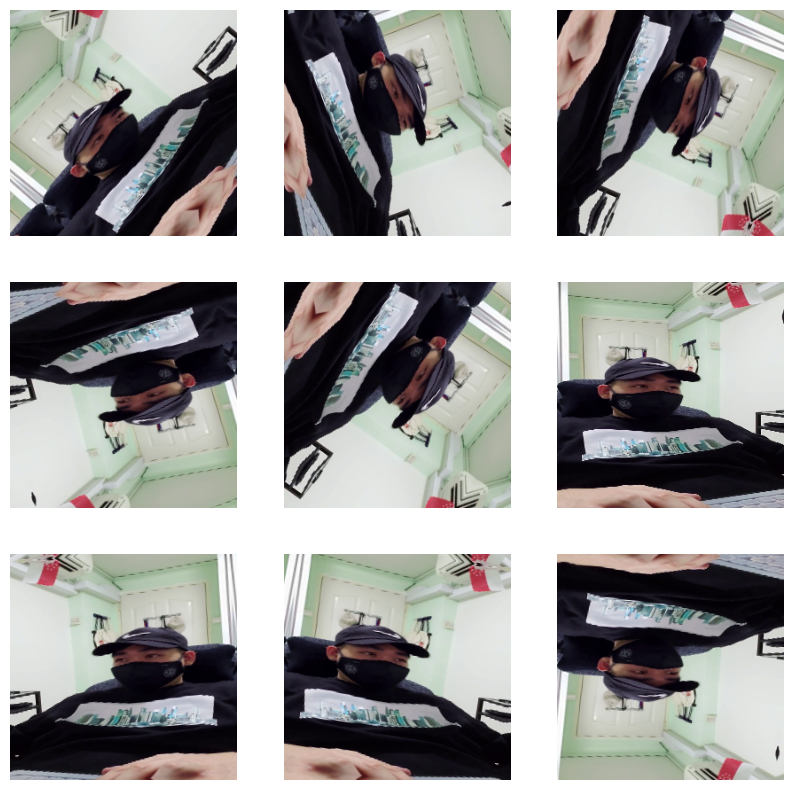

In [15]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(sample_image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

### Apply the preprocessing layers to the datasets

In [16]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [17]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

# Defining the model

In [18]:
# Basic Keras model
num_classes = len(class_names)

model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
# Compile model
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

model.build((None, IMG_SIZE, IMG_SIZE, 3))

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 22, 22, 64)       

# Training the model

In [21]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-11-10 21:57:47.724764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 4 of 1000
2023-11-10 21:57:57.857511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 14 of 1000
2023-11-10 21:58:17.486614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 37 of 1000
2023-11-10 21:58:28.543108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 46 of 1000
2023-11-10 21:58:47.508183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 66 of 1000
2023-11-10 21:58:57.580878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while)

89/89 [==============================] - 204s 1s/step - loss: 0.7518 - accuracy: 0.6184 - val_loss: 0.6290 - val_accuracy: 0.6082
Epoch 2/10


2023-11-10 22:01:10.335058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 3 of 1000
2023-11-10 22:01:30.463871: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 25 of 1000
2023-11-10 22:01:50.164457: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 47 of 1000
2023-11-10 22:02:00.363249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 58 of 1000
2023-11-10 22:02:19.619933: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 87 of 1000
2023-11-10 22:02:19.639639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 180s 1s/step - loss: 0.5505 - accuracy: 0.7099 - val_loss: 0.5328 - val_accuracy: 0.7440
Epoch 3/10


2023-11-10 22:04:09.461519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 4 of 1000
2023-11-10 22:04:19.640929: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 16 of 1000
2023-11-10 22:04:30.178258: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 30 of 1000
2023-11-10 22:04:49.571502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 55 of 1000
2023-11-10 22:05:00.099821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 68 of 1000
2023-11-10 22:05:10.235613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while)

89/89 [==============================] - 163s 1s/step - loss: 0.4986 - accuracy: 0.7576 - val_loss: 0.4905 - val_accuracy: 0.7539
Epoch 4/10


2023-11-10 22:06:53.587893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2023-11-10 22:07:04.157490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 17 of 1000
2023-11-10 22:07:23.505839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 43 of 1000
2023-11-10 22:07:33.720806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 56 of 1000
2023-11-10 22:07:53.097160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 81 of 1000
2023-11-10 22:07:53.307656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 156s 954ms/step - loss: 0.4693 - accuracy: 0.7710 - val_loss: 0.4639 - val_accuracy: 0.7666
Epoch 5/10


2023-11-10 22:09:29.151412: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 6 of 1000
2023-11-10 22:09:49.074821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 30 of 1000
2023-11-10 22:09:59.196915: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 43 of 1000
2023-11-10 22:10:18.869691: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 68 of 1000
2023-11-10 22:10:29.377250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 156s 954ms/step - loss: 0.4428 - accuracy: 0.7936 - val_loss: 0.4899 - val_accuracy: 0.7270
Epoch 6/10


2023-11-10 22:12:05.423389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2023-11-10 22:12:15.465964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 17 of 1000
2023-11-10 22:12:25.580058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 31 of 1000
2023-11-10 22:12:45.183461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 57 of 1000
2023-11-10 22:12:55.470443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 70 of 1000
2023-11-10 22:13:04.526735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 154s 945ms/step - loss: 0.4260 - accuracy: 0.8007 - val_loss: 0.4544 - val_accuracy: 0.7595
Epoch 7/10


2023-11-10 22:14:39.747061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2023-11-10 22:14:49.852165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 17 of 1000
2023-11-10 22:15:09.839242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 43 of 1000
2023-11-10 22:15:29.112572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 68 of 1000
2023-11-10 22:15:39.720895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 155s 942ms/step - loss: 0.4136 - accuracy: 0.8011 - val_loss: 0.4412 - val_accuracy: 0.7878
Epoch 8/10


2023-11-10 22:17:14.178443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2023-11-10 22:17:24.690646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 18 of 1000
2023-11-10 22:17:44.234288: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 45 of 1000
2023-11-10 22:17:54.698356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 58 of 1000
2023-11-10 22:18:12.492898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 154s 955ms/step - loss: 0.3983 - accuracy: 0.8191 - val_loss: 0.4020 - val_accuracy: 0.7949
Epoch 9/10


2023-11-10 22:19:48.353166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2023-11-10 22:19:58.486816: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 17 of 1000
2023-11-10 22:20:08.511868: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 30 of 1000
2023-11-10 22:20:28.682600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 57 of 1000
2023-11-10 22:20:38.781649: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 70 of 1000
2023-11-10 22:20:47.771975: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 153s 925ms/step - loss: 0.3742 - accuracy: 0.8300 - val_loss: 0.4394 - val_accuracy: 0.7921
Epoch 10/10


2023-11-10 22:22:20.693191: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 5 of 1000
2023-11-10 22:22:31.126313: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 18 of 1000
2023-11-10 22:22:51.394026: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 46 of 1000
2023-11-10 22:23:10.776892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:17: Filling up shuffle buffer (this may take a while): 72 of 1000
2023-11-10 22:23:17.788686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


89/89 [==============================] - 152s 948ms/step - loss: 0.3561 - accuracy: 0.8318 - val_loss: 0.4105 - val_accuracy: 0.8076


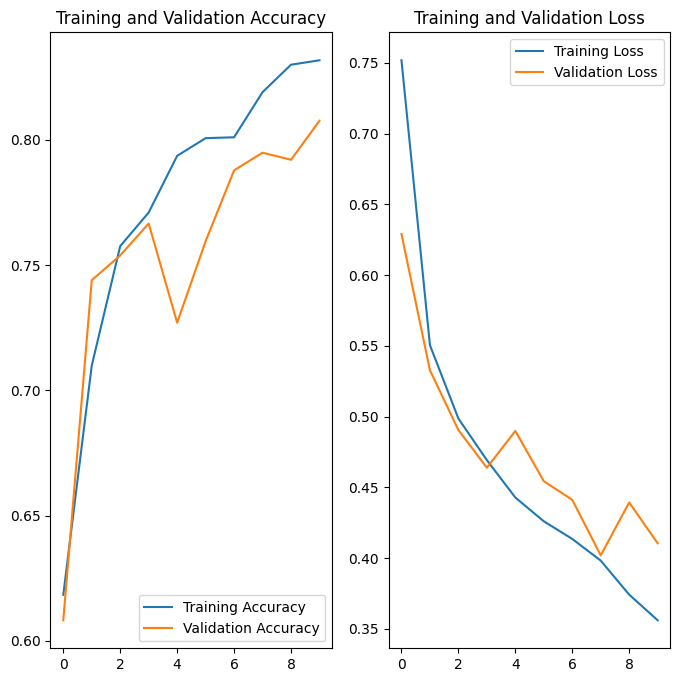

In [22]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = np.array(range(epochs))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model

In [23]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_frames)
test_ds = prepare(test_ds)

Found 2071 files belonging to 2 classes.


In [24]:
loss, accuracy = model.evaluate(test_ds)

65/65 [==============================] - 57s 786ms/step - loss: 0.9293 - accuracy: 0.5688


In [25]:
predicted_labels = []
ground_labels = []

for image_batch, label_batch in test_ds:
  batch_predictions = model.predict(image_batch, verbose=0)
  scores = tf.nn.softmax(batch_predictions)
  predicted_labels += [np.argmax(score) for score in scores]
  ground_labels += [label for label in label_batch]

predicted_labels = np.array(predicted_labels)
ground_labels = np.array(ground_labels)

Text(0.5, 1.0, 'Confusion Matrix')

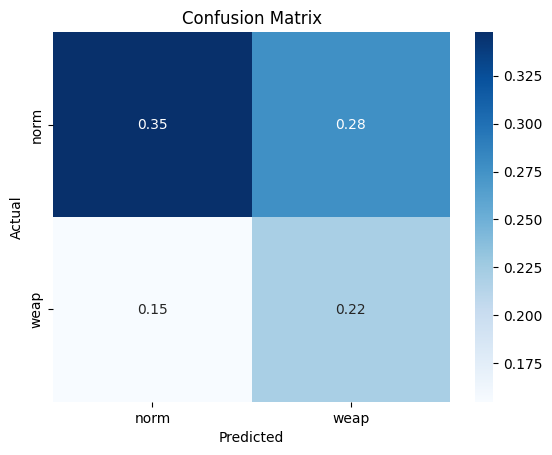

In [26]:
confusion_matrix = tf.math.confusion_matrix(ground_labels, predicted_labels, num_classes=num_classes)
sns.heatmap(confusion_matrix / np.sum(confusion_matrix), annot=True, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')